In [247]:
import torch
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

## Q1: How likely is the maximum increase to occur in lower triangle (top-down), and how likely is the maximum decrease to occur in upper triangle (bottom-up)?
Conclusion: top-down processing is possibly more effective at sharpening, while bottom-up processing is possibly more effective at dampening.

In [280]:
import re
from pathlib import Path
from itertools import product

modulators = []
modulator_type = []
modulator_strength = []

seeds = []
network_names = []

from_layer = []
to_layer = []

from_layer_idx = []
to_layer_idx = []

dampening_score = []
sharpening_score = []

direction = []

# Parse and load contioning matrices
for record in Path("../outs").glob("*/conditioning_*"):
    # Name indicates the modulator
    modulator = record.name

    # Parent indicates network name and seed
    network_name, seed = record.parent.name.split("_")

    # Load the matrices
    sharpen_scores, dampen_scores, layer_names = torch.load(record)

    # Make a dataframe
    for layer_from, layer_to in product(range(len(layer_names)), repeat=2):
        modulators.append(modulator)
        mod_type, mod_strength = re.split("_|\(|\)", modulator)[1:3]

        modulator_type.append(mod_type)
        modulator_strength.append(float(mod_strength.split("=")[1]))

        seeds.append(seed)
        network_names.append(network_name)

        from_layer.append(layer_names[layer_from])
        to_layer.append(layer_names[layer_to])

        from_layer_idx.append(layer_from)
        to_layer_idx.append(layer_to)

        if layer_from == layer_to:
            direction.append("self")
        elif layer_from < layer_to:
            direction.append("bottom-up")
        elif layer_from > layer_to:
            direction.append("top-down")

        sharpening_score.append(float(sharpen_scores[layer_from, layer_to]))
        dampening_score.append(float(dampen_scores[layer_from, layer_to]))

df = pd.DataFrame({
    "modulator": modulators,
    "modulator_type": modulator_type,
    "seed": seeds,
    "network_name": network_names,
    "from_layer": from_layer,
    "to_layer": to_layer,
    "from_layer_idx": from_layer_idx,
    "to_layer_idx": to_layer_idx,
    "sharpening_score": sharpening_score,
    "dampening_score": dampening_score,
    "direction": direction
})

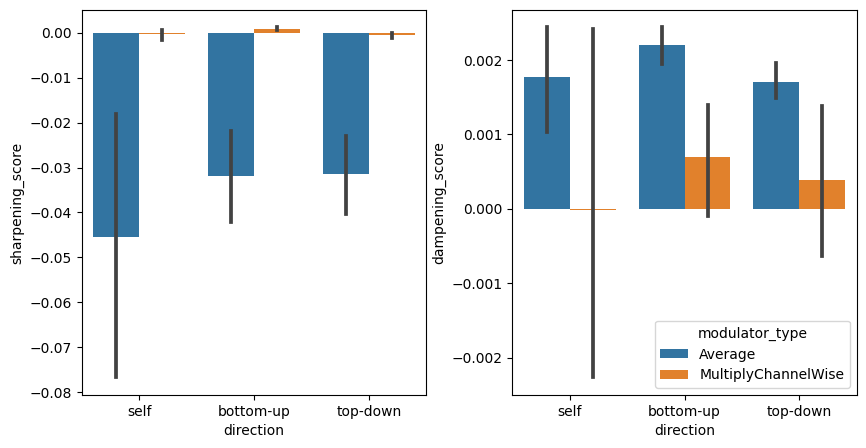

In [282]:
# Filter by model
model = "resnet34"

# Only look at average and multiply channel wise
df = df.query("modulator_type in ['Average', 'MultiplyChannelWise']")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Adjust size
fig.subplots_adjust(wspace=0.25)

# Plot the results as bar plots, two subplots
chart1 = sns.barplot(data=df[df["network_name"] == model], x="direction", y="sharpening_score", hue="modulator_type", ax=axes[0])
chart2 = sns.barplot(data=df[df["network_name"] == model], x="direction", y="dampening_score", hue="modulator_type", ax=axes[1])

# Turn off chart 1 legend
chart1.legend_.remove()

## Q2: plot upper, lower triangle mean wrt alpha

In [175]:
models_eval = ["resnet34"]

metric_direction = []
models = []
metric_type = []
metric = []
alphas = []
seeds = []

for model in models_eval:
    for alpha in range(10):
        for seed in range(5):
            try:
                scores_increase, scores_decrease, layer_names = torch.load(f"../outs/{model}_{seed}/conditioning_alpha0.{alpha}.pt")
            except FileNotFoundError:
                continue

            # Get the top mean and bottom mean
            increase_top_mean = torch.max(scores_increase[torch.triu(torch.ones_like(scores_increase), diagonal=1) == 1])
            metric_type.append("top-down")
            metric.append(float(increase_top_mean)*100)
            metric_direction.append("Sharpening")

            increase_bottom_mean = torch.max(scores_increase[torch.tril(torch.ones_like(scores_increase), diagonal=1) == 1])
            metric_type.append("bottom-up")
            metric.append(float(increase_bottom_mean)*100)
            metric_direction.append("Sharpening")

            decrease_top_mean = torch.max(scores_decrease[torch.triu(torch.ones_like(scores_decrease), diagonal=1) == 1])
            metric_type.append("top-down")
            metric.append(float(decrease_top_mean)*100)
            metric_direction.append("Dampening")

            decrease_bottom_mean = torch.max(scores_decrease[torch.tril(torch.ones_like(scores_decrease), diagonal=1) == 1])
            metric_type.append("bottom-up")
            metric.append(float(decrease_bottom_mean)*100)
            metric_direction.append("Dampening")

            alphas.extend([alpha] * 4)
            seeds.extend([seed] * 4)
            models.extend([model] * 4)

df = pd.DataFrame({"Conditioning direction": metric_type, "Score (%)": metric, "Metric type": metric_direction, "alpha": alphas, "seed": seeds})

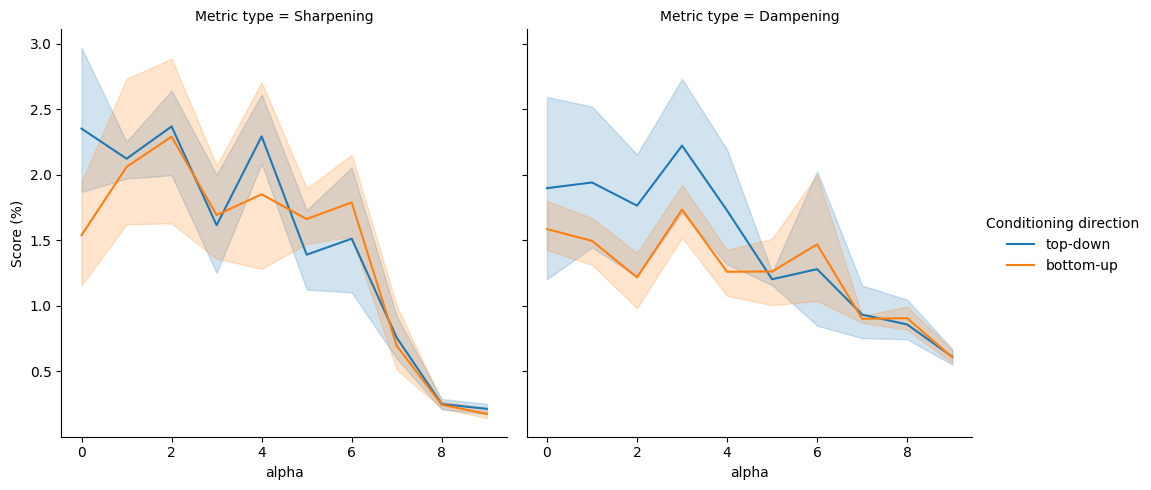

In [176]:
# Plot
chart = sns.relplot(x="alpha", y="Score (%)", hue="Conditioning direction", col="Metric type", kind="line", data=df)